In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import rawpy
import glob
import os


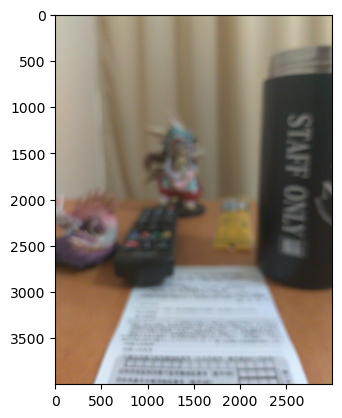

(4000, 3000, 3)


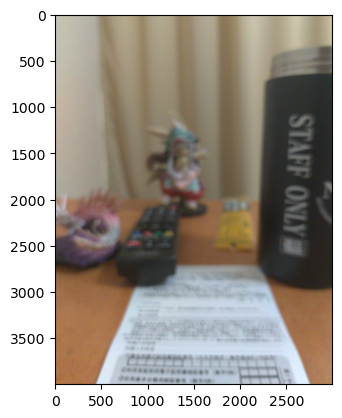

(4000, 3000, 3)


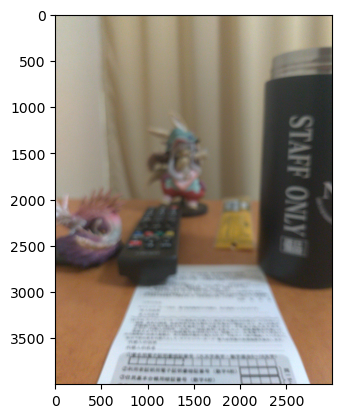

(4000, 3000, 3)


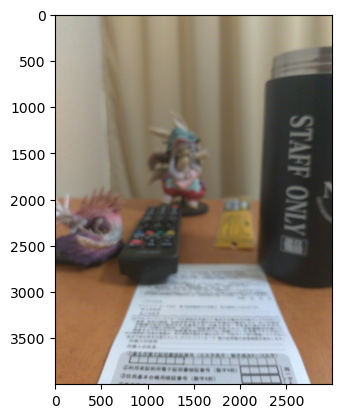

(4000, 3000, 3)


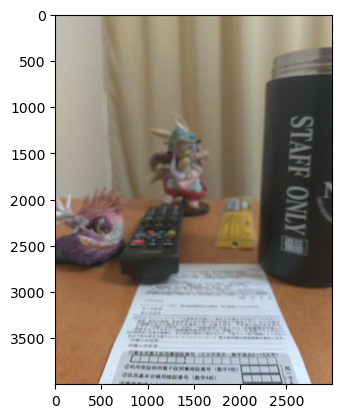

(4000, 3000, 3)


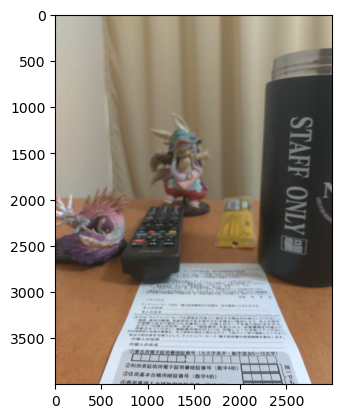

(4000, 3000, 3)


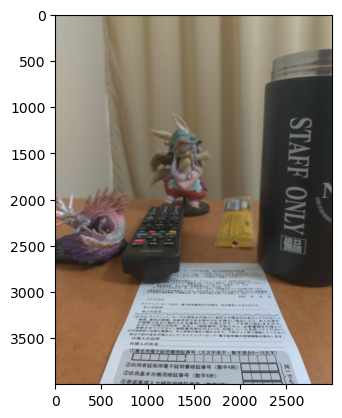

(4000, 3000, 3)


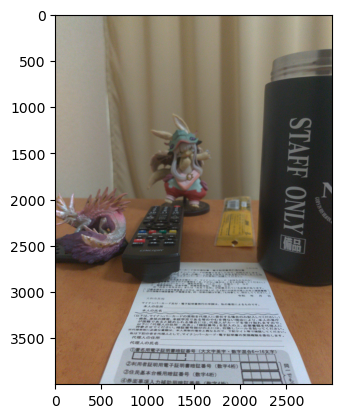

(4000, 3000, 3)


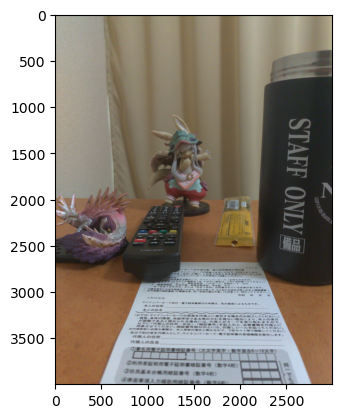

(4000, 3000, 3)


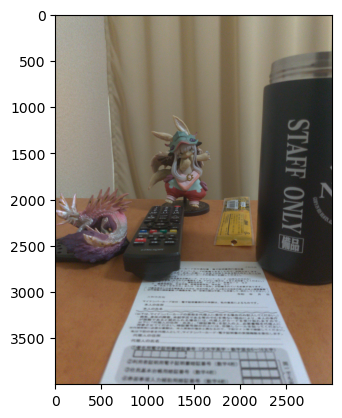

(4000, 3000, 3)


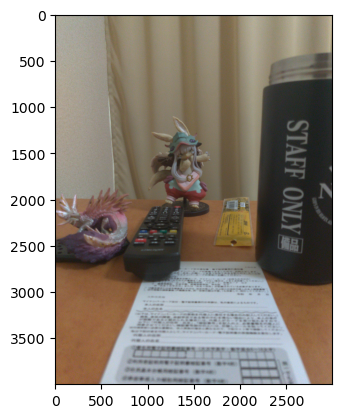

(4000, 3000, 3)


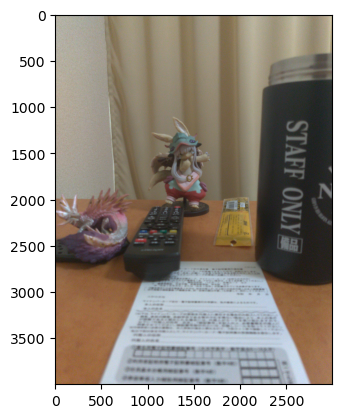

(4000, 3000, 3)


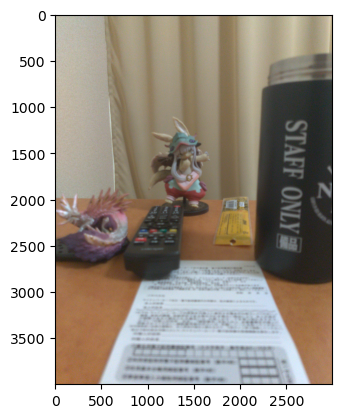

(4000, 3000, 3)


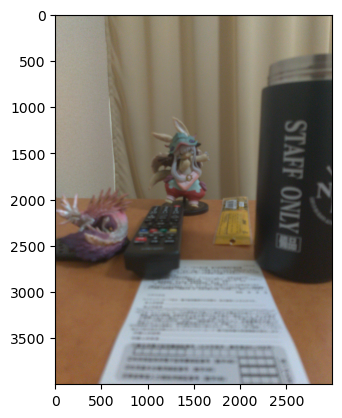

(4000, 3000, 3)


In [21]:
# read all images in the folder
folderPath = "..\\images\\Final\\1\\"
images = []
for file in glob.glob(folderPath + "*.dng"):
    with rawpy.imread(file) as raw:
        rgb = raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True)
        images.append(rgb)
        plt.imshow(rgb)
        plt.show() 
        print(rgb.shape)


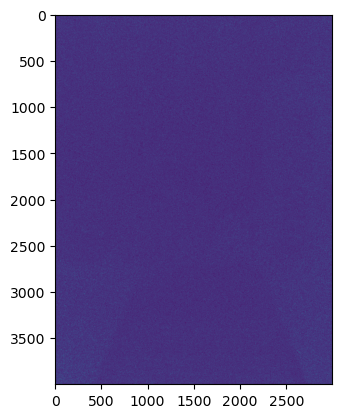

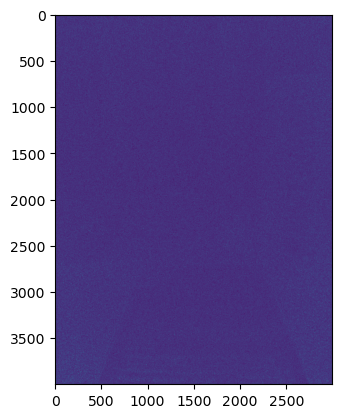

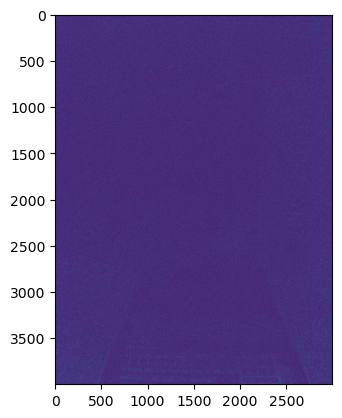

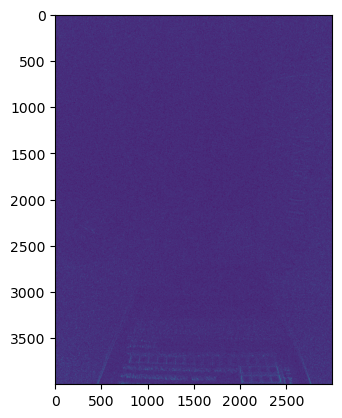

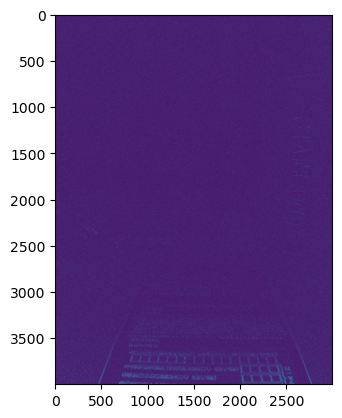

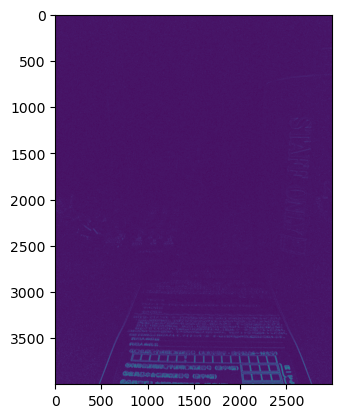

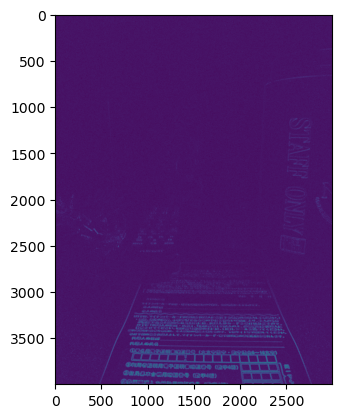

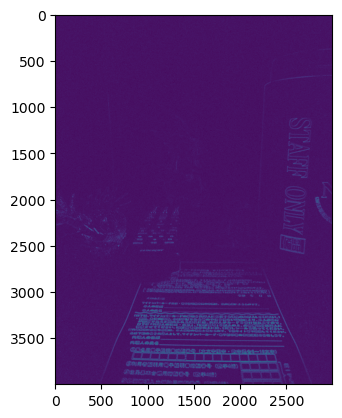

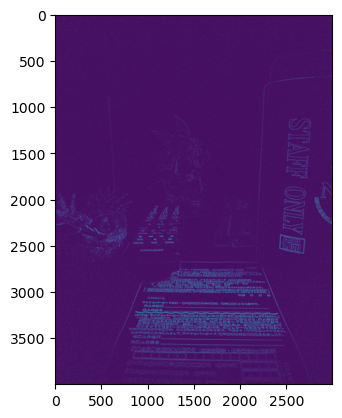

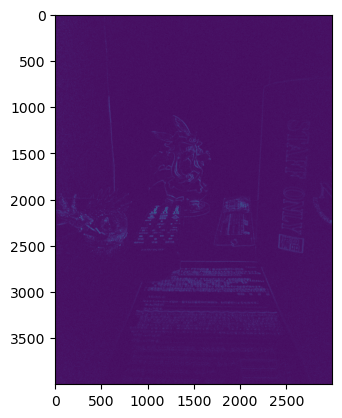

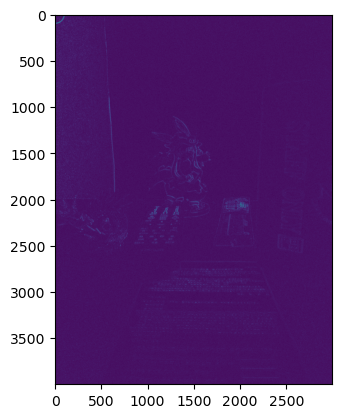

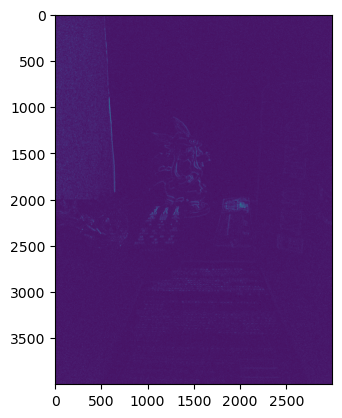

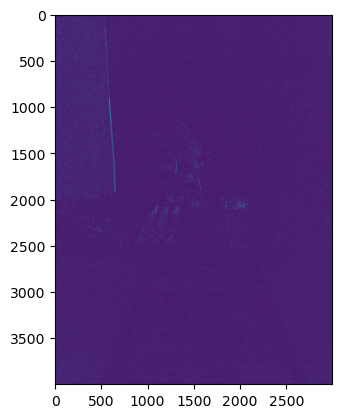

In [25]:
#FOCUS MESURE
def focus(images):
    focus_images = []
    for image in images:
        focus_images.append(cv.convertScaleAbs(cv.Laplacian(cv.cvtColor(cv.GaussianBlur(image, (9,9),0), cv.COLOR_BGR2GRAY), cv.CV_64F, ksize=3)))
    return focus_images
focus_images = focus(images)
for image in focus_images:
    plt.imshow(image)
    plt.show()

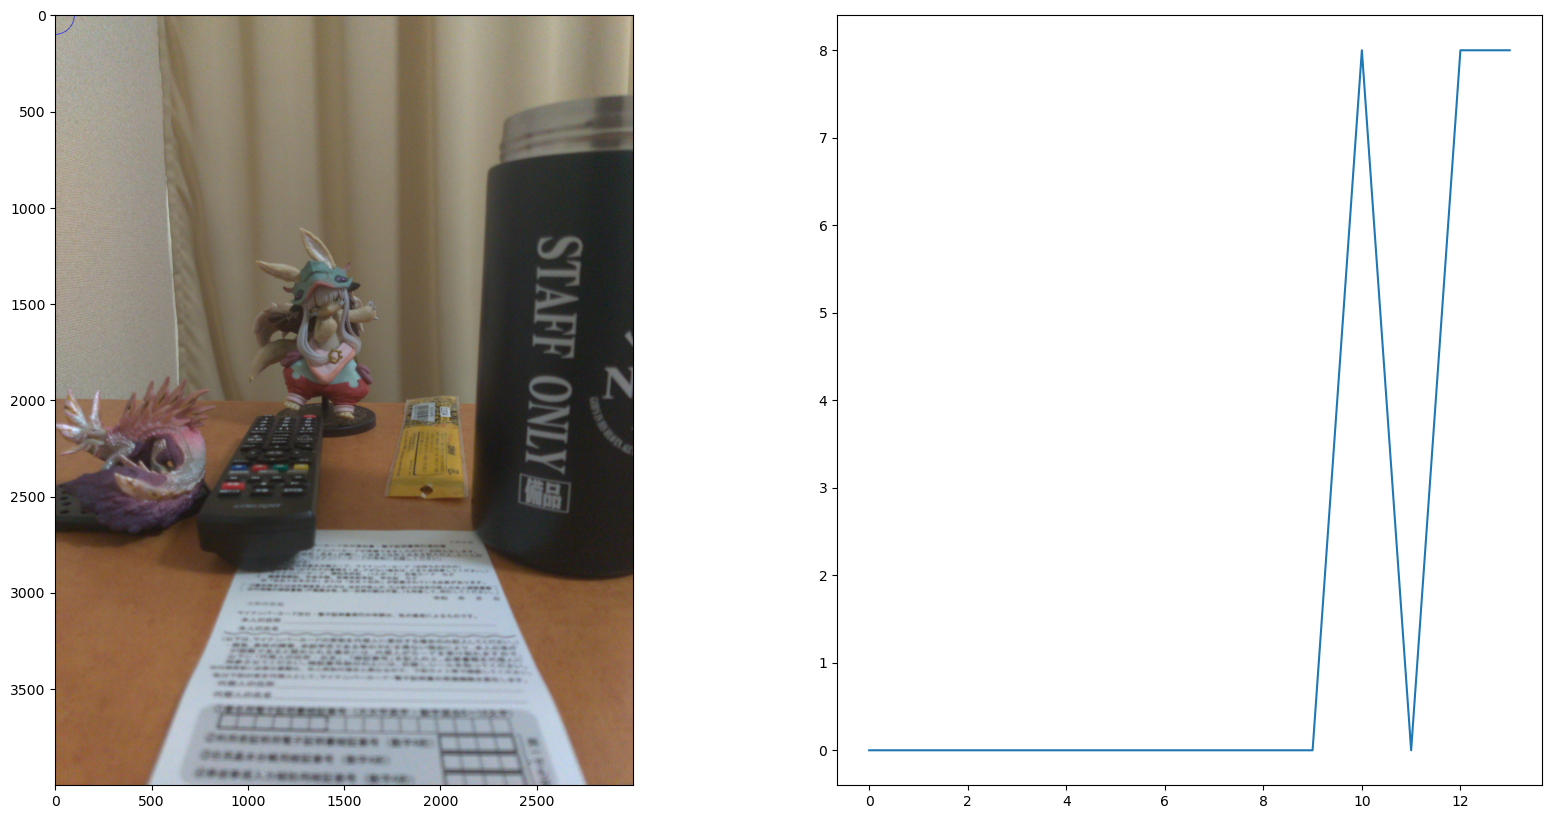

In [26]:
def show_focus_curve(images,focus_images, wanted_i, wanted_j):
    focus_curve = []
    base_image = images[10]
    for image in focus_images:
        focus_curve.append(image[wanted_i][wanted_j])
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    cv.circle(base_image, (wanted_j, wanted_i), 100, (0, 0, 255), 2)
    plt.imshow(base_image)
    plt.subplot(1,2,2)
    plt.plot(focus_curve)
    plt.show()
show_focus_curve(images,focus_images, 0, 0)

In [2]:
# General
WEIGHTS = np.array(
        [[0, 0, 1, 2, 1, 0, 0],
        [0, 1, 2, 3, 2, 1, 0],
        [1, 2, 3, 4, 3, 2, 1],
        [2, 3, 4, 5, 4, 3, 2],
        [1, 2, 3, 4, 3, 2, 1],
        [0, 1, 2, 3, 2, 1, 0],
        [0, 0, 1, 2, 1, 0, 0]])

def convert_to_grayscale(img):
    imGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return imGray

def read_image(image_path):
    with rawpy.imread(image_path) as raw:
        rgb = raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True)
        return rgb

def save_image(save_path, save_as, img):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    cv.imwrite(save_path + save_as, img)

def find_all_files(path):
    all_files = []

    for file in glob.glob(path + "*.dng"):
        all_files.append(file)
    return all_files

def read_images_from_path(img_path):
    img_list = []
    for file in glob.glob(img_path + "*.dng"):
        img_list.append(read_image(file))
    return img_list

def normalize(x):
    max_, min_ = np.max(x), np.min(x)
    normalized = (x - min_) / (max_ - min_)
    return normalized

In [ ]:
def focus_stack(aligned_img, gaussian_size, laplacian_size):
    imGray = convert_to_grayscale(aligned_img)
    gaussian_img = cv.GaussianBlur(imGray, (gaussian_size, gaussian_size), 0)
    laplacian_img = cv.Laplacian(gaussian_img, cv.CV_64F, ksize=laplacian_size)
    return laplacian_img

def focus_measure_cal(cost_volume, kernel_size=9):
    focus_measure = np.zeros_like(cost_volume)
    kernel = np.ones((kernel_size, kernel_size))

    for i in range(len(cost_volume)):
        focus_img = cost_volume[i]
        focus_measure[i] = focus_img*focus_img
        focus_measure[i] = cv.filter2D(focus_measure[i], -1, kernel)
    return focus_measure

def all_in_focus(img_list, cost_volume, kernel_size, gaussian_size):
    bgr_imgs = np.asarray(img_list)
    
    all_in_focus_img = np.zeros_like(bgr_imgs[0])
    height, weidth, channels = all_in_focus_img.shape

    focus_measure = focus_measure_cal(cost_volume, kernel_size)
    argmax = np.argmax(focus_measure, axis=0)

    normalized = 255 - (normalize(argmax) * 255)
    depth_map = cv.GaussianBlue(normalize, (gaussian_size, gaussian_size), 0)


    for i in range(height):
        for j in range(weidth):
            idx = argmax[i][j]
            all_in_focus_img[i][j][:] = bgr_imgs[idx,i,j,:]
    return depth_map, all_in_focus_img


def main(base_path):
    img_path = base_path + "images\\"
